In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
from numpy.random import seed
seed(42)

import tensorflow
tensorflow.random.set_seed(42)

In [16]:
import os
import pandas as pd
import math
import numpy as np

### Dataframes

In [17]:
REPOSITORY_PREFIX = 'https://raw.githubusercontent.com/RonildoSilva/datasets/main/'

In [18]:
# BPI12
df_train = pd.read_csv(REPOSITORY_PREFIX+'df_train_keras_tk_bpi_12_activity.csv')
df_test = pd.read_csv(REPOSITORY_PREFIX+'df_test_keras_tk_bpi_12_activity.csv')
df_val = pd.read_csv(REPOSITORY_PREFIX+'df_val_keras_tk_bpi_12_activity.csv')


In [19]:
df_train.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59',
       'datetime', 'Duration', 'PassedTime', 'Step', 'TimeConclusion'],
      dtype='object')

In [20]:
df_train = df_train[df_train['TimeConclusion'] != 0]
df_val = df_val[df_val['TimeConclusion'] != 0]
df_test = df_test[df_test['TimeConclusion'] != 0]

In [21]:
MAX_LEN_TRACE_TRAIN = df_train['Step'].max()

In [22]:
#len(df_test['Case ID'].unique())

In [23]:
df_test_ml = pd.concat([df_val,df_test])

In [24]:
df_test_ml['Step'].max()

56

### Features selection

In [25]:
FEATURES_COL = df_train.columns.tolist()
FEATURES_COL.remove('TimeConclusion')
FEATURES_COL.remove('datetime')

TARGET_COL = 'TimeConclusion'

In [26]:
ACT_COLS = df_train.columns.tolist()
ACT_COLS.remove('TimeConclusion')
ACT_COLS.remove('datetime')
ACT_COLS.remove('Duration')
ACT_COLS.remove('PassedTime')
ACT_COLS.remove('Step')

TARGET_COL = 'TimeConclusion'

In [27]:
TIME_COLS = ['Duration', 'PassedTime', 'Step']

In [28]:
print(ACT_COLS, sep='')

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59']


In [29]:
X_train = df_train[FEATURES_COL]
X_train = X_train.values

y_train = df_train[TARGET_COL].values


X_test = df_test[FEATURES_COL]
X_test = X_test.values

y_test = df_test[TARGET_COL].values


X_val = df_val[FEATURES_COL]
X_val = X_val.values

y_val = df_val[TARGET_COL].values

In [30]:
X_test_ml = np.concatenate((X_test, X_val), axis=0)
y_test_ml = np.concatenate((y_test, y_val), axis=0)


In [31]:
print(X_train.shape)

(80454, 63)


In [32]:
print(X_test_ml.shape)

(54168, 63)


### ML Experiment

In [33]:
! pip install xgboost

In [34]:
! pip install lightgbm

In [35]:
! pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.4 MB/s eta 0:00:00


In [37]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
import lightgbm as ltb
from catboost import CatBoostRegressor, Pool

regressors = [
        {'nome' : 'DummyRegressor', 'regressor':  DummyRegressor(strategy='mean')},
        {'nome' : 'LinearRegression', 'regressor': LinearRegression(fit_intercept=False)},
        {'nome' : 'RandomForestRegressor',  'regressor': RandomForestRegressor(n_estimators=20, max_features='auto',
                                                                              bootstrap=True, warm_start=True, max_depth=19, random_state=0)},
        {'nome' : 'XGBoostRegressor', 'regressor': XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)},
        {'nome' : 'LightGBM Regressor', 'regressor': ltb.LGBMRegressor(random_state=0)}
        #{'nome' : 'CatBoostRegressor', 'regressor': CatBoostRegressor()}

]

In [38]:
max_len_trace = df_train['Step'].max()

In [39]:
ML_EXPERIMENT = False

In [40]:
import time
from sklearn.metrics import mean_absolute_error


if(ML_EXPERIMENT):
  cols = [
          'Nome do modelo', 'MAE'
        ]

  data_result = []

  for regressor in regressors:
      t1 = time.time()
      if(regressor['nome'] == 'LightGBM Regressor'):
        regr = regressor['regressor'].fit(X_train, y_train, categorical_feature=[i for i in range(0,MAX_LEN_TRACE_TRAIN+1)])
      else:
        regr = regressor['regressor'].fit(X_train, y_train)
      tf = time.time()

      y_pred = regr.predict(X_test_ml)
      mae = mean_absolute_error(y_test_ml, y_pred)

      line = [
          regressor['nome'],
          mae
      ]
      data_result.append(line)

  pd.DataFrame(data_result, columns=cols).sort_values(by='MAE', ascending=True)

In [41]:
MAX_STEP = df_test_ml['Step'].max()

In [42]:

if(ML_EXPERIMENT):

  for regressor in regressors:
    step = list()
    mae = list()

    print(regressor)
    regr = regressor['regressor'].fit(X_train, y_train)
    for i in range(1, MAX_STEP+1):
      df_local_test = df_test_ml[df_test_ml['Step'] == i]
      dl_x__local_test = df_local_test[FEATURES_COL].values

      y_local_test = df_local_test[TARGET_COL]

      local_test_predicton = regr.predict(dl_x__local_test)
      mae_error = mean_absolute_error(y_local_test, local_test_predicton)

      mae.append(mae_error)
      step.append(i)

    for s, m in zip(step,mae):
      print(s,m)

### Deep learning Experiment

Deep learning model definition

In [43]:
#! pip install keras_self_attention

In [44]:
#from keras_self_attention import SeqSelfAttention

In [45]:
import keras

from tensorflow import keras
import tensorflow as tf

from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import PReLU
from keras.layers import BatchNormalization
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Reshape
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Masking

from tensorflow.keras.layers import concatenate

from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot

from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback


from keras.layers.core import Activation
from keras.initializers import Constant

from keras.regularizers import l2

In [46]:
dl_x_train = df_train[ACT_COLS].values
dl_x_val = df_val[ACT_COLS].values
dl_x_test = df_test[ACT_COLS].values

In [47]:
dl_x_t_train = df_train[TIME_COLS].values
dl_x_t_val = df_val[TIME_COLS].values
dl_x_t_test = df_test[TIME_COLS].values

In [48]:
dl_x_train = dl_x_train.reshape(dl_x_train.shape[0], dl_x_train.shape[1], 1)
dl_x_val = dl_x_val.reshape(dl_x_val.shape[0], dl_x_val.shape[1], 1)
dl_x_test = dl_x_test.reshape(dl_x_test.shape[0], dl_x_test.shape[1], 1)

In [49]:
dl_x_t_train = dl_x_t_train.reshape(dl_x_t_train.shape[0], dl_x_t_train.shape[1], 1)
dl_x_t_val = dl_x_t_val.reshape(dl_x_t_val.shape[0], dl_x_t_val.shape[1], 1)
dl_x_t_test = dl_x_t_test.reshape(dl_x_t_test.shape[0], dl_x_t_test.shape[1], 1)

In [50]:
n_activities = pd.concat([df_train, df_val, df_test], ignore_index=True)[ACT_COLS].to_numpy().max()

In [51]:
n_activities

24

In [52]:
shape = len(ACT_COLS)
shape_t = len(TIME_COLS)

- input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
- output_dim: Integer. Dimension of the dense embedding.


In [53]:
! pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=ae5ff7d1fed0633d6e61a79b4243fb8da815335a02ed2906eafeeca52fcbe641
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [54]:
from keras_self_attention import SeqSelfAttention

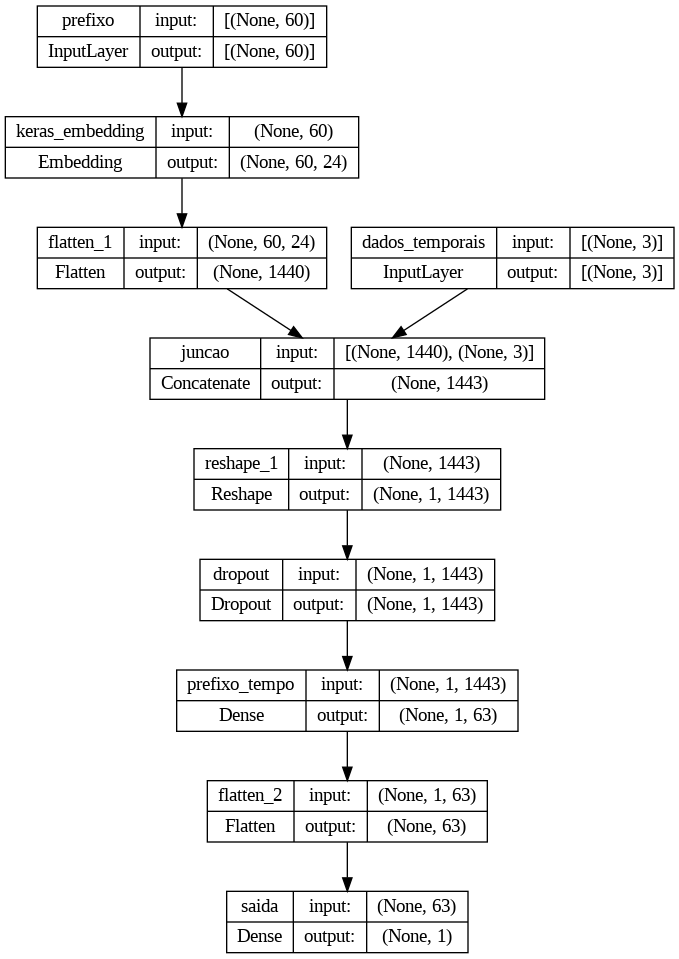

In [56]:
seq_length = len(ACT_COLS)
seq_length_t = len(TIME_COLS)

input_dim = n_activities + 1

activity_input = Input(shape=(seq_length,), name='prefixo')
time_input = Input(shape=(shape_t,), name='dados_temporais')

embedding_size = n_activities

embedding = Embedding(output_dim=embedding_size,
                      input_dim=input_dim,
                      input_length=seq_length,
                      name='keras_embedding')(activity_input)

"""
att = SeqSelfAttention(
    attention_activation='relu',
    name='Attention')(embedding)
"""

f = Flatten()(embedding)
x = concatenate([f, time_input], name='juncao')
x = Reshape((1, 1443, ), input_shape = (1443, ))(x)

x = Dropout(0.2)(x)

x = Dense((seq_length + seq_length_t),
          activation='relu',
          name='prefixo_tempo')(x)

x = Flatten()(x)

x = Dense(1, activation='linear', name='saida')(x)

model = Model(inputs=[activity_input , time_input], outputs=[x])

#model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [57]:
nadam = keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.7, beta_2=0.9, epsilon=1e-07, name="Nadam")

adam = keras.optimizers.Nadam(learning_rate=0.01, epsilon=0.01)

model.compile(
    optimizer=nadam,
    loss="mean_absolute_error",
    metrics=["mean_absolute_error"]
)

es = EarlyStopping(monitor='mean_absolute_error',
                   min_delta=1e-07, #min_delta=1e-04,
                   patience=50, verbose=1)

history = model.fit([dl_x_train, dl_x_t_train], y_train,
                    epochs=1000,
                    batch_size=1200,
                    callbacks=[TqdmCallback(verbose=0), es],
                    validation_data=[[dl_x_val, dl_x_t_val], y_val],
                    verbose=0)

0epoch [00:00, ?epoch/s]

Epoch 302: early stopping


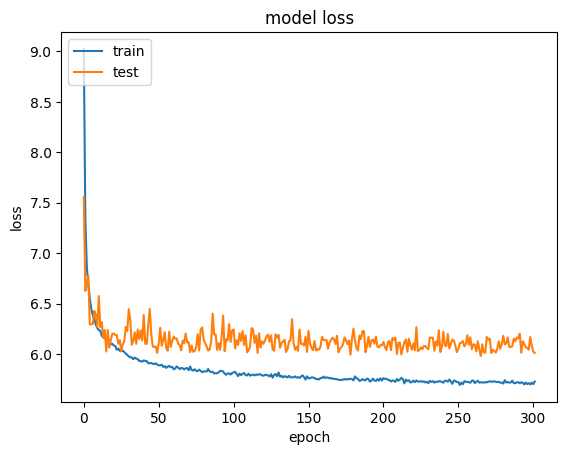

In [58]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [59]:
test_predicton = model.predict([dl_x_test,dl_x_t_test])

796/796 [==============================] - 2s 2ms/step


In [60]:
test_predicton.shape

(25445, 1)

In [61]:
y_test.shape

(25445,)

In [62]:
mae_error = mean_absolute_error(y_test, test_predicton)
print(mae_error)

4.250063697964174


In [63]:
from google.colab import files

df_results = pd.DataFrame(list(zip(y_test, np.squeeze(test_predicton))),columns =['y_test', 'y_pred'])
df_results.to_csv('C) BPI12_DENSE_PRED_REAL.csv', index=False)

files.download('C) BPI12_DENSE_PRED_REAL.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [64]:
MAX_STEP = df_test['Step'].max()

In [65]:
MAX_STEP

54

In [66]:
df_test['Step'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54])

In [67]:
step = list()
mae = list()

for i in range(1, MAX_STEP+1):
  df_local_test = df_test[df_test['Step'] == i]
  dl_x__local_test = df_local_test[ACT_COLS].values
  dl_x_t_local_test = df_local_test[TIME_COLS].values

  y_local_test = df_local_test[TARGET_COL]
  local_test_predicton = model.predict([dl_x__local_test,dl_x_t_local_test])
  mae_error = mean_absolute_error(y_local_test, local_test_predicton)

  mae.append(mae_error)
  step.append(i)

1/1 [==============================] - 0s 20ms/step


In [68]:
for s, m in zip(step,mae):
  print(s,m)

1 6.822405242997098
2 5.749905177232159
3 5.575946087719506
4 5.5151029995256575
5 4.965227931463961
6 4.934753866074056
7 4.687729479771821
8 4.421955339878868
9 4.249977482752113
10 4.1527430891862664
11 3.8556761469924727
12 3.1950263911482075
13 3.6153979779997716
14 3.6044461202680345
15 3.254579022568092
16 2.9786831160708926
17 2.5235917597584767
18 2.3588831532053236
19 2.1473069888408265
20 2.0130013369901656
21 2.319199005906241
22 1.8297448290790401
23 1.6468897229835344
24 1.7142159011940827
25 1.4200917619727182
26 1.3322278938596814
27 1.487331360850033
28 1.5481983496710912
29 1.5957617024245785
30 1.468321089170571
31 1.3054736463086811
32 1.3302562532277542
33 1.2248706761543569
34 1.1876479079204065
35 1.178654796235953
36 1.1238344938325098
37 0.9454030323665791
38 0.9746372850573581
39 1.1838924863379576
40 0.8819450055507512
41 0.861239433764418
42 0.6904820196735859
43 0.697300135231018
44 0.8494710977276166
45 1.0114148652601243
46 0.894312915195359
47 1.18190665

In [69]:
for s, m in zip(step,mae):
  print(str(round(m, 4)).replace('.',','))

6,8224
5,7499
5,5759
5,5151
4,9652
4,9348
4,6877
4,422
4,25
4,1527
3,8557
3,195
3,6154
3,6044
3,2546
2,9787
2,5236
2,3589
2,1473
2,013
2,3192
1,8297
1,6469
1,7142
1,4201
1,3322
1,4873
1,5482
1,5958
1,4683
1,3055
1,3303
1,2249
1,1876
1,1787
1,1238
0,9454
0,9746
1,1839
0,8819
0,8612
0,6905
0,6973
0,8495
1,0114
0,8943
1,1819
1,0484
0,9702
1,1167
1,3425
2,5688
2,4832
3,7778


In [70]:
np.mean(mae)

2.3669395011158487